# Interior Point Methods

This tour explores the use of [interior point methods](https://en.wikipedia.org/wiki/Interior-point_method) for constraint minimization under positivity constraints.

The definite reference for this Numerical Tour is the book ["Convex Optimization"](https://web.stanford.edu/~boyd/cvxbook/) of Boyd and Vandenberghe, which is a must read.

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\DeclareMathOperator{\eqdef}{\overset{\tiny def}{=}}$

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt

Useful helpers.

In [2]:
def dotp(x,y):
    return np.sum( x.flatten()*y.flatten() )
np.random.seed(123) # to ensure reproductibitily 

## Problem formulation

The goal is to solve problem of the form:
$$
    (\mathcal{S}_\infty) \qquad \umin{x\in \RR^d, A x \leq b} f(x)
$$
for $A \in \RR^{m \times d}$.

This can be generalized for instance by replacing $A x$ by a matrix and $\leq$ by PSD matrix inequalities.

## Lasso Primal Problem

The [Lasso problem](https://en.wikipedia.org/wiki/Lasso_(statistics)) (applied to the regression problem $Bw \approx y$ for the design matrix $B \in \RR^{n \times p}$)
$$
		(\mathcal{P}_\la) \qquad 
        \umin{w \in \RR^p} \frac{1}{2}\norm{Bw-y}^2 + \la \norm{w}_1
$$

Set the parameters $(n,p)$ of the Lasso problem and generate a random Gaussian matrix (so that the problem is a [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing) problem, with $n<p$).

In [3]:
n = 40
p = 60
B = np.random.randn(n,p)

Generate the observations as $y = B w_0 + N$ where $N$ is a small additive noise and $w_0$ is a sparse vector that we aim at recovering.

In [4]:
w0 = np.zeros((p,1)) 
I = ( np.array([.1, .25, .6, .9])*p ).astype(int)
w0[I] = np.array([.8, -.6, .7, -.9])[:,None]
N = np.random.randn(n,1)*np.max(np.abs(B@w0))*.02
y = (B@w0) + N

We set $\lambda = \lambda_{\max}/10$ where $\lambda_{\max} \eqdef \norm{B^\top y}_\infty$ is the parameter for witch the solution of the Lasso is 0.

In [5]:
lamda = np.max(np.abs(B.T @ y))/10

The Lasso $(\mathcal{P}_\la)$ can be re-casted as the generic problem $(\mathcal{S}_\infty)$ by introducing the positive/negative decomposition $x=(x_-,x_+) \in \RR^{2p}$ (so that $d=2p$)  and $w = x_+ - x_-$ with $(x_+,x_-) \geq 0$, so that  
$$ 
    f(x) = \frac{1}{2}\norm{B(x_+-x_-)-y}^2 + \la \dotp{x}{1}
$$ 
and $A=-\text{Id}_{2p}$, $b=0$ (so that $m=2p$).

In [6]:
m = 2*p
d = 2*p
A = -np.eye(d)
b = np.zeros((d,1))

Define the function $f$ and check its correctness.

In [7]:
def f(x):
    return 1/2*np.linalg.norm( B@(x[0:p]-x[p:]) - y )**2 + lamda*np.sum(x)

In [8]:
w = w0
x = np.concatenate([np.maximum(w,0),np.maximum(-w,0)])
a = 1/2*np.linalg.norm(B@w-y)**2 + lamda*np.linalg.norm(w,1)
print('Should be 0: ' + str(a - f(x))) 

Should be 0: 0.0


Implements its gradient $\nabla f(x) = (h,-h) + \lambda$ where $h \eqdef B^\top ( B (x_+-x_-)-y)$.

In [9]:
def nablaf(x):
    h = B.T@( B@(x[0:p]-x[p:]) - y )
    return np.concatenate([h,-h]) + lamda

Check its correctness using finite differences
$$
    \frac{f(x+\tau u)-f(x)}{\tau} \approx \dotp{\nabla f(x)}{u}
$$

In [10]:
tau = 1e-7
u = np.random.randn(d,1)
m2 = (f(x+tau*u)-f(x))/tau
m1 = dotp( u, nablaf(x) );
print('Should be 0: ' + str( abs(m1-m2)/abs(m1) ) )

Should be 0: 1.46806858635393e-05


Implements its hessian 
$$
    \partial^2 f(x) = \begin{pmatrix} B^\top B & -B^\top B \\ -B^\top B & B^\top B\end{pmatrix}.
$$

In [11]:
BB = B.T @ B
H = np.block([[BB,-BB], [-BB, BB]])
def hessianf(x):
    return H

Check its correctness using finite differences
$$
    \frac{\nabla f(x+\tau u)-\nabla f(x)}{\tau} \approx \partial^2 f(x) u
$$

In [12]:
m2 = (nablaf(x+tau*u)-nablaf(x))/tau
m1 = hessianf(x)@u;
print('Should be 0: ' + str(np.linalg.norm(m1-m2)/np.linalg.norm(m1)) )

Should be 0: 1.6742776164296532e-10


## Newton method to compute the central path

The main idea of interior point methods is to approximate $(\mathcal{S}_\infty)$ using a logarithmic [barrier function](https://en.wikipedia.org/wiki/Barrier_function)
$$
	(\mathcal{S}_t) \qquad \umin{x\in \RR^d, } f_t(x) \eqdef f(x) - \frac{1}{t} \text{Log}( b-A x  )
$$
where 
$$
	\text{Log}(u) \eqdef \sum_i \log(u_i)
$$
so that -Log is a strictly concave function which acts as a barrier for positivity. 
On recovers the initial problem $(\mathcal{S}_\infty)$ in the limit of $(\mathcal{S}_t)$ when $t \rightarrow +\infty$, i.e. in some sense $f + \iota_{A \cdot \leq y} = f_\infty$. 

The fonction $\log(s)$ should be $-\infty$ for $s < 0$, this is extremely important for the following.

In [13]:
def Log(v):
    w = v
    w[v<=0] = -np.inf
    w[v>0] = np.log(w[v>0])
    return np.sum(w)

The gradient and hessian of $f_t$ read
$$
	\nabla f_t(x) = \nabla f(x) + \frac{1}{t} A^\top \frac{1}{y-Ax}
	\qandq
	\partial^2 f_t(x) = \partial^2 f(x) + \frac{1}{t} A^\top \text{diag}\pa{\frac{1}{(y-Ax)^2}} A.
$$

In [14]:
def ft(x,t):
    if t<0:
        return f(x)
    else:
        return f(x) - 1/t * Log(b - A@x)
def nablaft(x,t):
    return nablaf(x) + 1/t * A.T @ (1/(b - A@x))
def hessianft(x,t):
    return hessianf(x) + 1/t * A.T @ np.diag( 1/(b-(A@x))[:,0]**2 ) @ A

In [15]:
t = 10
x = .5 + np.random.rand(d,1)
u = .5*np.random.randn(d,1)
m2 = (ft(x+tau*u,t)-ft(x,t))/tau
m1 = dotp( u, nablaft(x,t) );
print('Should be 0: ' + str(abs(m1-m2)/abs(m1)) )
m2 = (nablaft(x+tau*u,t)-nablaft(x,t))/tau
m1 = hessianft(x,t)@u;
print('Should be 0: ' + str(np.linalg.norm(m1-m2)/np.linalg.norm(m1)) )

Should be 0: 6.905096885932568e-07
Should be 0: 2.9706266473930562e-09


Initialize the algorithm using a feasible point, i.e. here $x>0$.

In [16]:
x = .01*np.ones((d,1))

For a fixed $t$, one can solve $(\mathcal{S}_t)$ using [Newton method](https://en.wikipedia.org/wiki/Newton%27s_method) with some [line search](https://en.wikipedia.org/wiki/Line_search) procedure to select the step size $0<\tau_\ell\leq 1$
$$
	(N) \qquad  x_{k+1} \eqdef x_k + \tau_\ell d_k 
    \quad\text{where}\quad
    d_k \eqdef -[ \partial^2 f_t(x_k)]^{-1} \nabla f_t(x_k)
$$


In [17]:
dk = - np.linalg.solve(hessianft(x,t),nablaft(x,t))

The use of a backtracking is extremely important in our case to ensure that the iterate stays within the constraints.

The simplest linesearch rule is [Armijo](https://en.wikipedia.org/wiki/Backtracking_line_search), which imposes that, for some $0 < \al < 1/2$ one has
$$
    \text{(AC)}\qquad
    \phi_k(\tau_k) \eqdef f(x_k + \tau_k d_k )
    <
    \psi_k(\tau_k) \eqdef f(x_k) + \alpha \tau \dotp{d_k}{\nabla f(x_k)}. 
$$

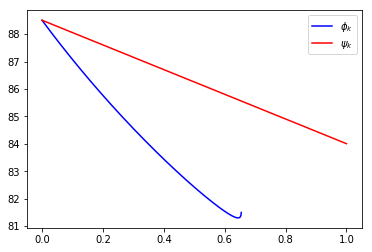

In [18]:
alpha = .3
def phik(tau):
    return ft(x+tau*dk,t)
def psik(tau):
    return ft(x,t) + tau*alpha*dotp(dk,nablaft(x,t))
phik = np.vectorize(phik)
psik = np.vectorize(psik)
tau = np.linspace(0,1,1000)
plt.plot(tau, phik(tau), 'b', label='$\phi_k$')
plt.plot(tau, psik(tau), 'r', label='$\psi_k$')
plt.legend();

A backtracking method then selects the step size by initializing $\tau_k=1$, and following a geometric decay by a factor $0<\be<1$ until Armijo conditon (AC) is satisfies. 

In [19]:
beta = 0.7
tauk = 1
while ft(x+tauk*dk,t)>ft(x,t)+alpha*tauk*dotp(nablaft(x,t),dk):
    tauk = beta*tauk

Once the step size is selected, perform the descent step $x_{k+1} \eqdef x_k+\tau_k d_k$.

In [20]:
x = x + tauk*dk

Now we implement the full Newton method by putting all these steps together. We also record the number of backtracking steps at each iterations.

In [21]:
def newton(ft,nablaft,hessianft,x,t,epsilon):
    ftlist = np.array([])
    flist = np.array([])
    backtrack = np.array([])
    while True:
        ftlist = np.append(ftlist, ft(x,t))
        flist = np.append(flist, ft(x,-1))
        dk = -np.linalg.solve(hessianft(x,t),nablaft(x,t))
        deltak = -dotp(nablaft(x,t),dk)
        if deltak<epsilon:
            break
        tauk = 1
        it = 0
        while ft(x+tauk*dk,t)>ft(x,t) - alpha*tauk*deltak:
            it = it+1
            tauk = beta*tauk
        backtrack = np.append(backtrack, it)
        x = x+tauk*dk
    return x, ftlist, backtrack, flist

Display in log scale the decay of the error and the numbr of backtracking step. When the number of such steps reaches 0, Newton's algortihm enter a quadratically convergence rate regime.

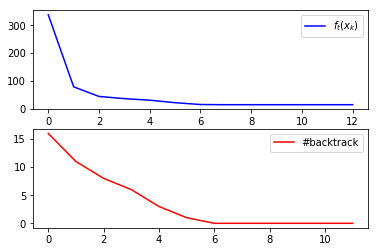

In [22]:
epsilon = 1e-6
t = 100
x = np.ones((d,1))
x, ftlist, backtrack, flist = newton(ft,nablaft,hessianft,x,t,epsilon)
plt.subplot(2, 1, 1)
plt.plot(ftlist, 'b', label='$f_t(x_k)$')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(backtrack, 'r', label='#backtrack');
plt.legend();

Display the solution $(x_+,x_-)$ computed, supperposed over the groud trust to recover $w_0$.

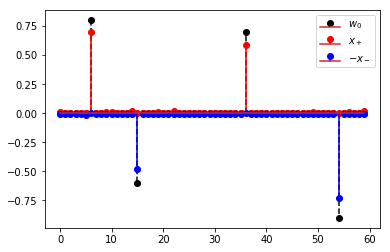

In [23]:
plt.stem( w0, linefmt='--k', markerfmt='ko', label='$w_0$' )
plt.stem( x[0:p], linefmt='-r', markerfmt='ro', label='$x_+$' )
plt.stem( -x[p:], linefmt='-b', markerfmt='bo', label='$-x_-$' )
plt.legend();

Display the evolution with $t$ of the solution computed.

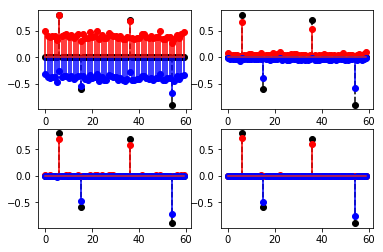

In [24]:
tlist = np.array([1, 10, 100, 1000])
for it in range(0,4):
    x, ftlist, backtrack, flist = newton(ft,nablaft,hessianft,x,tlist[it],epsilon)
    plt.subplot(2,2,it+1)
    plt.stem( w0, linefmt='--k', markerfmt='ko' )
    plt.stem( x[0:p], linefmt='-r', markerfmt='ro' )
    plt.stem( -x[p:], linefmt='-b', markerfmt='bo' )

Note that on this example, the primal solution $w^\star$ is supported on the same locations as the ground trust $w_0$ to recover. This indicates that $\ell^1$ regularization has succeeded in almost exactly (up to the impact of the noise) recover the unknown ground trust vector $w_0$, with the exact correct non zero locations. This is guaranteed by the theory of compressed sensing, which ensure exact recovery if $n = O(s \log(p/s))$ where $s$ is the number of non zero entries in $w_0$ (here $s=4$).

The interior point method
======

The [interior point method](https://en.wikipedia.org/wiki/Interior-point_method) proceeds by $f_t$ using (N) (defining an approximated "central" path $t \mapsto x(t)$) for a series of increasing step sizes $t \eqdef t_\ell=\mu^\ell t_0$ for some $\mu > 1$. The crucial point here is to use a "warm restart" strategy: in order to solve for $x(t_{\ell})$, one should initialize the Newton steps (N) using $x(t_{\ell-1})$. This is what makes interior point methods efficient.  Thanks to the use of a logarithmic barrier, one can show the upper bound $f(x(t_\ell))-f(x^\star) \leq m/t_\ell$ ($m$ being the number of scalar constraints), so that in order to a final error of $\epsilon$, one needs to use $\ell=0, \ldots, L$ such that 
$$
	\frac{m}{t_{L}} = \frac{m}{t_0 \mu^{L}} \leq \epsilon.
$$
This shows that only $O(|\log(\epsilon)|)$ steps are necessary to reach $\epsilon$ precision.

Implement the method, and store the values of $f(x_{k,\ell})$ during all the Newton steps $k$ for $t=t_\ell$. 

In [25]:
mu = 50
t = 1 
x = np.ones((d,1))
Flist = np.array([])
while m/t >= epsilon:
    x, ftlist, backtrack, flist = newton(ft,nablaft,hessianft,x,t,epsilon)
    Flist = np.append(Flist, flist)
    t = mu*t

Display the evolution of $f(x_{k,\ell})-f(x^\star)$ in logarithmic scale. This highlights the different steps of the algorithm (and migh even be non-decreasing), where the energy starts decaying and then stagnates, until $t=t_k$ is changed to $t=t_{k+1}$

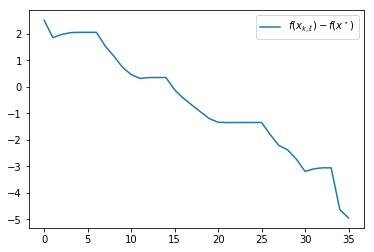

In [26]:
plt.plot( np.log10(Flist[0:-1]-np.min(Flist)), label='$f(x_{k,\ell})-f(x^\star)$' )
plt.legend();

To bound the running time of the IP method, the important question to bound the complexity of the method is thus to bound the number of Newton steps (N). This requires additional hypotheses on $f$. If the function $f$ has a so-called self-concordance property, namely that for any $(x,y)$, $\phi(s) \eqdef f(s x + (1-s)y)$ satisfies
$$
	|\phi'''(s)| \leq 2 \phi''(s)^{3/2}, 
$$
one can then that only a constant number of Newton steps are required per iterations (note that $-\log$ being self-concordant, and quadratic function are self concordant, $f_t$ is itself self-concordant) when using the warm-restart initialization to computes the succession of $x(t_\ell)$. 
This result might look surprising, but is possible because of the combination of the warm restart strategy with the self-concordance property of $f_t$: although problems become more and more difficult ($f_t$ is becoming less regular) as $t$ increases, the number of iterations of Newton stays constant.
This fundamental result supports the claim that interior point methods solve linear programs (and more general types of problems including SDP problems) in polynomial time (where polynomial refers to polynomial in $\log(\epsilon)$).

We want to display the influence of $\mu$ on the decay of the energy. For this we first compute an accurate appoximation of $f(x^\star)$ using a small $\epsilon$.

In [27]:
mu = 200
t = 1 
x = np.ones((d,1))
Flist = np.array([])
while m/t >= epsilon/100:
    x, ftlist, backtrack, flist = newton(ft,nablaft,hessianft,x,t,epsilon/100)
    t = mu*t
fmin = np.min(flist)

Display the influence of $\mu$. One can see that unless one used very small or very large $\mu$, all the runs are in the same ballpark, and one observe approximately a linear rate of convergence, with a constant number of inner Newton steps (index $k$) per interior point step (index $\ell$).

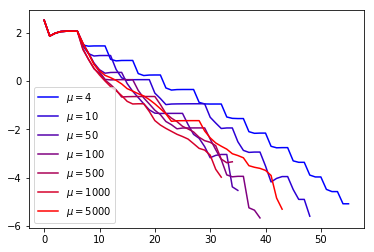

In [28]:
mulist = np.array([4, 10, 50, 100, 500, 1000, 5000])
for it in range(0,len(mulist)):
    mu = mulist[it]
    t = 1 
    x = np.ones((d,1))
    Flist = np.array([])
    while m/t >= epsilon:
        x, ftlist, backtrack, flist = newton(ft,nablaft,hessianft,x,t,epsilon)
        Flist = np.append(Flist, flist)
        t = mu*t
    s = it/(len(mulist)-1)
    plt.plot( np.log10(Flist[0:-1]-fmin), color=(s,0,1-s), label='$\mu=' + str(mu) +'$' )
plt.legend();

Interior Point Method for the Dual of the Lasso
=====

The dual of the Lasso $(\mathcal{P}_\la)$ (written for simplicity as a convex minimization instead of a concave maximization) reads
$$
		(\mathcal{D}_\la) \qquad
        \umin{\norm{B^\top q}_\infty \leq 1} f(q) = \frac{\la}{2}\norm{q}^2 - \dotp{q}{y}.
$$
It has the form $(\mathcal{S}_\infty)$ when setting $A=\begin{pmatrix} B^\top \\-B^\top \end{pmatrix}$ and $b = 1_{2p}$ (so that $d=n$ and $m=2p$).

In [29]:
m1 = 2*p
d1 = n
A = np.concatenate((B.T,-B.T), axis=0)
b = np.ones((m1,1))

Implement $f$ and its derivative.

In [30]:
def f1(q):
    return lamda/2*np.linalg.norm(q)**2 - dotp(q,y)
def nablaf1(q):
    return lamda*q - y
def hessianf1(q):
    return lamda*np.eye(n)

Re-define the function $f_t$ and its derivatives.

In [31]:
def f1t(q,t):
    if t<0:
        return f1(q)
    else:
        return f1(q) - 1/t * Log(b - A@q)    
def nablaf1t(q,t):
    return nablaf1(q) + 1/t * A.T @ (1/(b - A@q))
def hessianf1t(q,t):
    return hessianf1(q) + 1/t * A.T @ np.diag( 1/(b-(A@q))[:,0]**2 ) @ A

Run Newton with the logarithmic barrier on the dual problem $(\mathcal{D}_\la)$.
A feasible initialization is simply $q=0$.

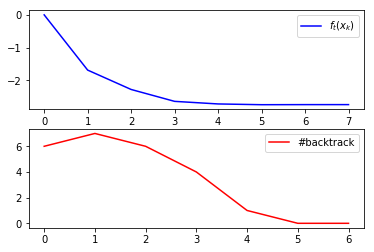

In [32]:
t = 100
q, ftlist, backtrack, flist = newton(f1t,nablaf1t,hessianf1t,np.zeros((d1,1)),t,epsilon)
plt.subplot(2, 1, 1)
plt.plot(flist, 'b', label='$f_t(x_k)$')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(backtrack, 'r', label='#backtrack');
plt.legend();

Display how much the dual solution is strictly inside the constraints.

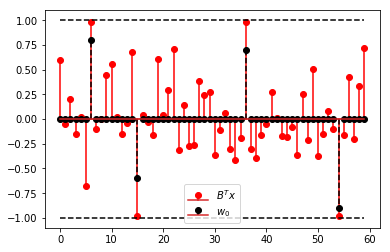

In [33]:
eta = B.T @ q
plt.stem( eta, linefmt='-r', markerfmt='ro', label='$B^T x$' )  
plt.plot( eta*0+1, 'k--' )    
plt.plot( eta*0-1, 'k--' ) 
plt.stem( w0, linefmt='--k', markerfmt='ko', label='$w_0$' ) 
plt.legend();

The primal-dual relation between optimal primal/dual solutions $(w^\star,x^\star)$ (note that $q^\star$ is unique because the dual problem is srongly convex) reads
$$
       q^\star = \frac{y-B w^\star}{\la}
       \qandq
       \{ i : w^\star_i \neq 0 \} \subset 
       \{ i : |(B^\top q^\star)_i| = 1\}
$$
which explains why in the above plot the points where $B^\top q$ approximatively saturates the constraints match the locations of the diracs in $w_0$ (since in this case, the primal solution $w^\star$ is supported on the same locations as the ground trust $w_0$ to recover). 

It is now possible to also implement the interior point method using Newton on the dual functional. The conclusion are the same as on the primal problem regarding the impact of $\mu$.

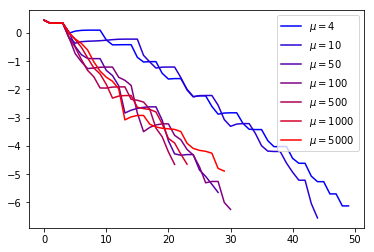

In [34]:
mu = 200
t = 1 
q = np.zeros((d1,1))
while m1/t >= epsilon/100:
    q, ftlist, backtrack, flist = newton(f1t,nablaf1t,hessianf1t,q,t,epsilon/100)
    t = mu*t
fmin = np.min(flist)
mulist = np.array([4, 10, 50, 100, 500, 1000, 5000])
for it in range(0,len(mulist)):
    mu = mulist[it]
    t = 1 
    q = np.zeros((d1,1))
    Flist = np.array([])
    while m/t >= epsilon:
        q, ftlist, backtrack, flist = newton(f1t,nablaf1t,hessianf1t,q,t,epsilon)
        Flist = np.append(Flist, flist)
        t = mu*t
    s = it/(len(mulist)-1)
    plt.plot( np.log10(Flist[0:-1]-fmin), color=(s,0,1-s), label='$\mu=' + str(mu) +'$' )
plt.legend();

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>